# Assignment 1

**Lecturer**: Vincent Claes<br>
**Authors:** Bryan Honof, Jeffrey Gorissen<br>
**Start Date:** 19/10/2018
    
**Objective:** Visualize and predict the future temperatures via ARIMA

## Table of contents

1. [Import Libraries](#Import-Libraries)
2. [Get Data](#Get-Data)  
    a. [Restructure the data to a time series](#Restructure-Data)  
3. [A bit of Exploratory Data Analysis (EDA)](#EDA)  



## 1. Import Libraries <a name="Import-Libraries"></a>

In [1]:
%matplotlib inline

import warnings
import itertools
import subprocess
import psycopg2

import pandas            as pd
import numpy             as np
import statsmodels.api   as sm
import matplotlib.pyplot as plt
import seaborn           as sns

from scipy import stats
from statsmodels.graphics.api import qqplot

sns.set()
warnings.filterwarnings('ignore')

## 2. Get Data <a name="Get-Data"></a>

We have 2 options here toggled by the 'in_school' variable.
If this variable is set to True we will obtain our data by pulling a JSON object from the heroku webserver.
If it is set to False we will obtain it by first connecting to the Heroku PostgreSQL database and applying a simple SQL querry to that database.

In [2]:
in_school = True

if (True == in_school):
    # Get the data from the web route because school blocks the port used by the database :)
    
    url = 'https://pxl-ss.herokuapp.com/api/temps'
    data = pd.read_json(url, orient='columns')
else:
    # Get the data directly from the database
    
    HEROKU_APP_NAME = "pxl-ss"
    TABLE_NAME = "Temperature"

    conn_info = subprocess.run(["heroku", "config:get", "DATABASE_URL", "-a", HEROKU_APP_NAME], stdout = subprocess.PIPE)
    connuri = conn_info.stdout.decode('utf-8').strip()

    engine = create_engine(connuri)
    raw_engine = engine.raw_connection()

    data = pd.read_sql_query("SELECT * FROM Temperature;", raw_engine)
    

print(data.head())

                      creation_date  id                          place  value
0  2018-11-10T23:38:44.453789+00:00   1  Lat:51.037460, Long: 5.301590  21.48
1  2018-11-10T23:53:53.134313+00:00   2  Lat:51.037460, Long: 5.301590  19.48
2  2018-11-10T23:53:57.457321+00:00   3  Lat:51.037460, Long: 5.301590  20.60
3  2018-11-10T23:56:10.690055+00:00   4  Lat:51.037460, Long: 5.301590  20.45
4  2018-11-10T23:58:49.577553+00:00   5  Lat:51.037460, Long: 5.301590  20.76


### a. Restructure the data to a time series <a name="Restructure-Data"></a>

The data we got from our source is has multiple tables we don't care about, we really only care about the 'creation_date' & 'value' column.<br>
We create a new pandas dataframe with only those 2 columns and rename them to a more human readable names: 'dateTime' & 'temperature'.

Afther renaming the columns we will have to convert them to the right data type. datetime for the 'dateTime' column and float for the 'temperature' column.

Since we are aiming to work with a time series we have to set the 'dateTime' column as the index.

In [3]:
# Filter out all the columsn except for 'creation_date' & 'value'
# Rename those columns to 'dateTime' & temperature
df = pd.DataFrame(data, columns = ['creation_date', 'value'])
df.columns = ['dateTime', 'temperature']

# Inspect data
#print(df.info())

# Convert the creation_date column to datetime64
# df['dateTime'] = pd.to_datetime(df['dateTime'])
df['dateTime'] = pd.to_datetime(df.dateTime)
# Convert the value column to float
df['temperature'] = pd.to_numeric(df.temperature)

# Set the dateTime column as index
df.set_index(['dateTime'], inplace=True)

# Inspect data
print(df.head())

                            temperature
dateTime                               
2018-11-10 23:38:44.453789        21.48
2018-11-10 23:53:53.134313        19.48
2018-11-10 23:53:57.457321        20.60
2018-11-10 23:56:10.690055        20.45
2018-11-10 23:58:49.577553        20.76


## 3. A bit of Exploratory Data Analysis (EDA) <a name="EDA"></a>

                            temperature
dateTime                               
2018-11-10 23:38:44.453789        21.48
2018-11-10 23:53:53.134313        19.48
2018-11-10 23:53:57.457321        20.60
2018-11-10 23:56:10.690055        20.45
2018-11-10 23:58:49.577553        20.76
                            temperature
dateTime                               
2018-11-17 09:15:14.339867        18.14
2018-11-17 09:30:23.476648        16.69
2018-11-17 09:45:28.374686        18.38
2018-11-17 10:00:37.981042        17.54
2018-11-17 10:15:43.103436        17.76
(584, 1)
Index(['temperature'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 584 entries, 2018-11-10 23:38:44.453789 to 2018-11-17 10:15:43.103436
Data columns (total 1 columns):
temperature    584 non-null float64
dtypes: float64(1)
memory usage: 9.1 KB
None


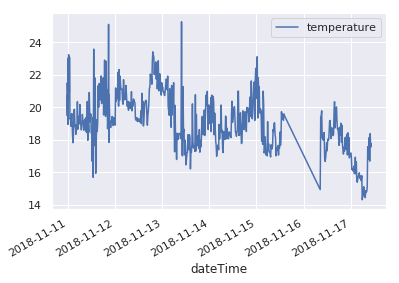

In [9]:
# Print the head of df
print(df.head(5))

# Print the tail of df
print(df.tail(5))

# Print the shape of df
print(df.shape)

# Print the columns of df
print(df.columns)

print(df.info())

# We can also notice some error by just looking at it visually
df.plot()
plt.show()

We can see in the plot that there is some missing data (by the plummeting line).